# Profession Clustering

Here we categorize each contestant's profession into one of nine classes according to the International Standard Classification of Occupations (http://www.ilo.org/public/english/bureau/stat/isco/isco08/index.htm). 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import requests
import json
from geopy import geocoders
import math
import gensim
import nltk
import difflib

/Users/seananmurphy/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Open contestant dictionaries with occupation data (from Wikipedia scrape).

In [2]:
#Import seasonsDict.json which contains hometown information
with open("tempdata/listAllDicts.json") as json_file:
    seasons = json.load(json_file)

In [3]:
#Make a function that get's contestant's profession for a given season
def get_profession(choose_season):
    town_dict = {}
    for idict in seasons:
        if idict["season"] == choose_season:
            if idict["elimination"] == "bachelor":
                bachtown = idict["occupation"]
            else:
                if idict["name"] == "Kacie Boguskie":
                    idict["occupation"] = "Administrative assistant"
                town_dict.update({idict['name']:idict['occupation']})
    return town_dict

In [4]:
#Download a csv of a list of classified professions from the ISCO
#https://en.wikipedia.org/wiki/International_Standard_Classification_of_Occupations
#http://www.ilo.org/public/english/bureau/stat/isco/isco08/index.htm
professions = pd.read_csv("professions.csv")
professions.head(3)


,ISCO 08 Code,Title EN
0,1,Managers
1,11,"Chief executives, senior officials and legisla..."
2,111,Legislators and senior officials


## Categorize 

We categorize by matching the contestants' profession to the list of keyed professions given by the ISCO. We only require 75% of a string match to cateogorize. If there are several profession types that match the contestants' profession, we categorize by finding which category gave the most matches.


Since not all contestant professions are given by the ISCO, we make exceptions for several edge cases - i.e. we manually categorize the professions to give a match. 

In [11]:
#nltk.download('maxent_treebank_pos_tagger')

season_nums = range(13,20)

#Run over all seasons
profession_dict = {}
for season_num in season_nums:
    profession_dict.update({season_num: get_occupation(season_num)})
    print "season ", season_num, " done"

[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /Users/seananmurphy/nltk_data...
[nltk_data]   Unzipping taggers/maxent_treebank_pos_tagger.zip.
season  13  done
season  14  done
season  15  done
season  16  done
season  17  done
season  18  done
season  19  done


In [9]:
#nltk.download('punkt')

prof_sent = map(lambda r: r.split(" "), professions["Title EN"].tolist())
isco_code = professions["ISCO 08 Code"].tolist()
prof_list = professions["Title EN"].tolist()

def get_occupation(season_num):
    #Get names and professions
    nprof = get_profession(season_num)
    conts = nprof.keys()
    all_jobs = nprof.values()

    #Make profession names cleaner for processing
    all_jobs = map(lambda r: r.replace("&",""), all_jobs)
    all_jobs = map(lambda r: r.replace("/"," "), all_jobs)
    all_jobs = map(lambda r: r.replace("  "," "), all_jobs)

    #Replace words we a prior (or post-priori) know will give problems to cluster
    all_jobs = [u"assistant" if "aralegal" in s else s for s in all_jobs]
    all_jobs = [u"lawyer" if "ttorney" in s else s for s in all_jobs]
    all_jobs = [u"Professionals" if s=="Wedding Coordinator" else s for s in all_jobs]
    all_jobs = [u"child care" if (s=="Nanny") | (s=="Homemaker") else s for s in all_jobs]
    all_jobs = [u"sales" if "merchant" in s else s for s in all_jobs]
    all_jobs = [u"dancer" if s=="Radio City Rockette" else s for s in all_jobs]
    all_jobs = [u"fashion model" if ("Model" in s) | ("model" in s) else s for s in all_jobs]
    all_jobs = [u"Hairdressers" if "tylist" in s else s for s in all_jobs]
    all_jobs = [u"sports" if s=="acrobat" else s for s in all_jobs]
    all_jobs = [u"executive recruiter" if s=="IT recruiter" else s for s in all_jobs]
    all_jobs = [u"Administrative Assistant" if s=="Assistant" else s for s in all_jobs]
    all_jobs = [u"beauticians" if ("sthetician" in s) | (s=="Salon Owner") | \
                (s=="Cosmetics Consultant") else s for s in all_jobs]
    all_jobs = [u"Songwriter singer" if s=="Singer-songwriter" else s for s in all_jobs]
    all_jobs = [u"Medical Assistant" if s=="Medical Technician" else s for s in all_jobs]
    all_jobs = [u"Advertising account manager" if s=="Advertising Executive" else s for s in all_jobs]
    all_jobs = [u"sports" if s=="WWE Diva-in-Training" else s for s in all_jobs]
    all_jobs = [u"doctor" if "hysician" in s else s for s in all_jobs]
    all_jobs = [u"author" if s=="Blogger" else s for s in all_jobs]
    all_jobs = [u"chief executive" if "ntrepreneur" in s else s for s in all_jobs]
    all_jobs = [u"food service" if "waitress" in s else s for s in all_jobs]
    all_jobs = [u"education" if ("student" in s) | ("Student" in s) else s for s in all_jobs]
    all_jobs = [u"Creative and performing artists" if "Theatre" in s else s for s in all_jobs]
    all_jobs = [u"Aircraft pilot" if s=='Commercial Pilot' else s for s in all_jobs]
    all_jobs = [u"education assistant" if s=='College Admissions' else s for s in all_jobs]
    all_jobs = [u"Management and organization analysts" if s=='Personal Organizer' else s for s in all_jobs]
    all_jobs = [u"Journalists" if s=='Local News Reporter' else s for s in all_jobs]
    all_jobs = [u"Medical assistants" if 'Nurse' in s else s for s in all_jobs]
    all_jobs = [u"Services managers not elsewhere classified" if s=='Nursing Home Owner' else s for s in all_jobs]
    all_jobs = [u"dancers" if "heerleader" in s else s for s in all_jobs]
    all_jobs = [u"Medical sales" if 'Cadaver Tissue Saleswoman' in s else s for s in all_jobs]
    all_jobs = [u"education" if s=='Guidance Counselor' else s for s in all_jobs]


    #Now we sift through the list of professions to just get the nouns
    #Our assumption is that the nouns of a profession provide the best classification
    all_nouns = []
    for sentence in all_jobs:
        stokens = nltk.word_tokenize(sentence)
        sent_noun = []
        for word, part_of_speech in nltk.pos_tag(stokens):
            if part_of_speech in ['NN', 'NNS', 'NNP', 'NNPS']:
                sent_noun.append(word)
        all_nouns.append(sent_noun)

    #Do a string search comparison with the professions.csv file
    #We match (with 75% accuracy) each contestant's profession with the ISCO professions
    #If there is a match, we save the category number (from 0xxx - 9xxx)
    prof_dict = {}
    all_codes = []
    all_names = []
    for iprof,sent in enumerate(all_nouns):
        for word in sent:
            for ii,profs in enumerate(prof_sent):
                wmatches = difflib.get_close_matches(word, profs, cutoff=.75)
                if wmatches:
                    all_names.append(prof_list[ii])
                    all_codes.append(isco_code[ii])
            
        #Get first value of codes
        fnum = map(lambda r: int(str(r)[0]), all_codes)
        counts = [fnum.count(q) for q in range(9)] #Count which code is most
        job_type = np.where(counts==np.max(counts))[0][0]
        if np.sum(counts) == 0:
            job_type=999
            
        #Append jobs type
        prof_dict.update({conts[iprof] : job_type})
        all_codes=[]
        all_names=[]
        
    return prof_dict


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/seananmurphy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [71]:
with open('profession_dict.json', 'w') as fp:
    json.dump(profession_dict, fp)

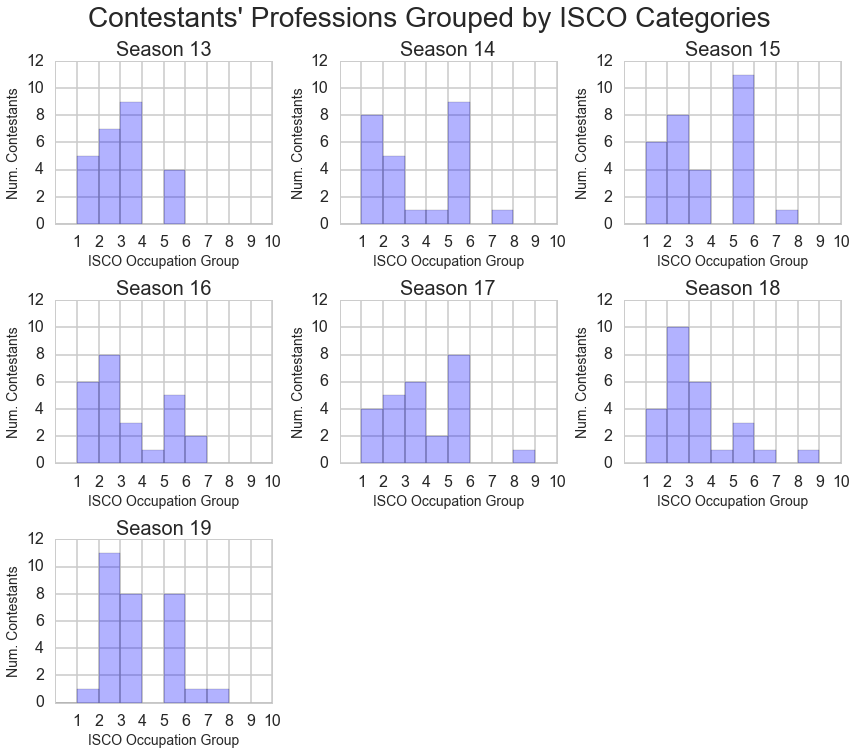

In [126]:
#plot histograms of contestants' professions grouped by ISCO categories
#
# input:
#     seasonNum  = Season number 
#     subPlotNum = subplot on grid of plots
#
def draw_histogram(seasonNum, subPlotNum):
    thisdict = profession_dict.get(seasonNum)     #get dictionary for this season
    dict_values = [i for i in thisdict.values()]  #get ISCO cateogory for each contestant
    
    #add subplot, make histogram
    ax = fig.add_subplot(3, 3, subPlotNum)        
    ax.hist(dict_values, bins=range(0, 10 + 1, 1), color='b', alpha=0.3)
    ax.set_ylim([0,12])
    ax.set_xticks(np.arange(1,11,1))
    
    #add axis labels
    ax.set_title('Season ' + `seasonNum`, fontsize=20)
    ax.set_xlabel("ISCO Occupation Group", fontsize=14)
    ax.set_ylabel("Num. Contestants", fontsize=14)


#set up figure 
fig = plt.figure(figsize=(12,11))
fig.suptitle("Contestants' Professions Grouped by ISCO Categories", fontsize=28)

#for each season, make histogram
plotNum = 1
for season in season_nums:
    draw_histogram(season, plotNum)
    plotNum += 1

#adjust grid layout
fig.tight_layout(rect=[0, 0.03, 1, 0.95])